<a href="https://colab.research.google.com/github/Irene-Zheng/Zyraland/blob/main/Individual_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter Code

In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark


import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

spark.version

'3.0.0'

In [2]:
print(spark.sparkContext)
print("Spark App Name : "+ spark.sparkContext.appName)

<SparkContext master=local[*] appName=pyspark-shell>
Spark App Name : pyspark-shell


In [3]:
#
# SparkContext stop() method
spark.sparkContext.stop()

# Individual Lab 2

In [71]:
#import libraries
import pyspark
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import RegressionEvaluator


In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## 2. Read 'BostonHousing.csv' dataset in PySpark.




In [6]:
#import BostonHousing dataset
from google.colab import files
files.upload()

Saving BostonHousing.csv to BostonHousing.csv


{'BostonHousing.csv': b'"crim","zn","indus","chas","nox","rm","age","dis","rad","tax","ptratio","b","lstat","medv"\n0.00632,18,2.31,"0",0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24\n0.02731,0,7.07,"0",0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6\n0.02729,0,7.07,"0",0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7\n0.03237,0,2.18,"0",0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4\n0.06905,0,2.18,"0",0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2\n0.02985,0,2.18,"0",0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7\n0.08829,12.5,7.87,"0",0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9\n0.14455,12.5,7.87,"0",0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1\n0.21124,12.5,7.87,"0",0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5\n0.17004,12.5,7.87,"0",0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9\n0.22489,12.5,7.87,"0",0.524,6.377,94.3,6.3467,5,311,15.2,392.52,20.45,15\n0.11747,12.5,7.87,"0",0.524,6.009,82.9,6.2267,5,311,15.2,396.9,13.27,18.9\n0.09378,12

In [51]:
data = spark.read.csv('BostonHousing.csv',inferSchema=True, header =True)

## 3. Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')

In [52]:
va_data = VectorAssembler(inputCols=data.columns[:-1], outputCol="features")
vector_data = va_data.transform(data)
vector_data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+
only showing top 5 rows



## 4. Standardize features for principal component analysis

In [53]:
scale = StandardScaler(inputCol="features", outputCol="StandardizedFeatures")
standard_data = scale.fit(vector_data).transform(vector_data)
standard_data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|StandardizedFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[7.34751712931429...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[0.00317501096205...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[0.00317268579840...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[0.00376327736512...|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|[0.06905,0.0,2.18...|[0.00802762749

## 5. Train model for two principal component analysis

In [54]:
pca= PCA(k=2, inputCol="StandardizedFeatures")
pca.setOutputCol("pcaFeatures")
pca_data = pca.fit(standard_data).transform(standard_data)
pca_data.show(5)


+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|            features|StandardizedFeatures|         pcaFeatures|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+--------------------+--------------------+--------------------+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|[0.00632,18.0,2.3...|[7.34751712931429...|[-1.2551263234672...|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|[0.02731,0.0,7.07...|[0.00317501096205...|[-1.8955383642584...|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|[0.02729,0.0,7.07...|[0.00317268579840...|[-1.2788028017576...|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|[0.03237,0.0,2.18...|[0.00376327736

## 6. Collect distributed data in numpy array and then convert to pandas dataframe

In [55]:
pca_data= pca_model.transform(data_scaled).select("pcaFeatures").collect()
pca_array = []
for d in pca_data:
  pca_array.append(d.pcaFeatures)
pca_array = np.array(pca_array)
pca_df = pd.DataFrame(pca_array, columns=["C1","C2"])
pca_df.head()

,C1,C2
0,-1.255126,0.619209
1,-1.895538,0.438260
2,-1.278803,0.445907
3,-0.742428,-0.160003
4,-0.895595,-0.055524


## 7. Plot two principal components

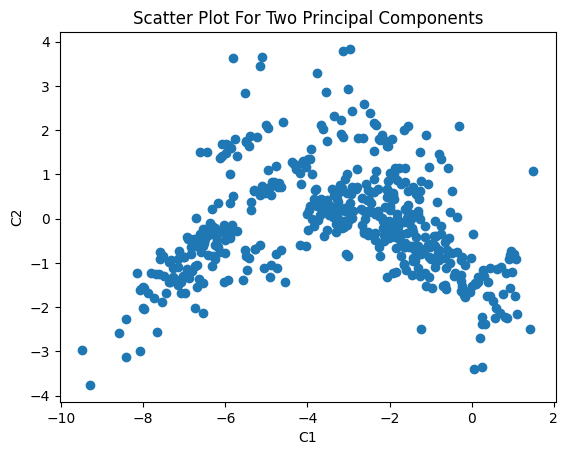

In [56]:
plt.scatter(pca_df["C1"], pca_df["C2"])
plt.title("Scatter Plot For Two Principal Components")
plt.xlabel("C1")
plt.ylabel("C2")
plt.show()

## 8. Vectorize features and target together for model development

In [57]:
with_target_data = vector_data.select("features","medv")
with_target_data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



## 9. Split dataset into training and testing dataset

In [63]:
splits = with_target_data.randomSplit([0.7,0.3], 111)
train = splits[0]
test = splits[1]
print(train.count())
print(test.count())

353
153


## 10. Fit model for linear regression

In [73]:
fit_linear = LinearRegression(featuresCol="features", labelCol="medv", predictionCol="predicted_train")
fit_train = fit_linear.fit(train)


## 11. Find out model coefficients and intercept

In [74]:
print("The model's coefficients for training set are:", fit_train.coefficients, ".  \n The intercept is:", fit_train.intercept)

The model's coefficients for training set are: [-0.10297190249258695,0.04344442820673411,-0.052243850078199705,2.644951465254376,-15.996937760425611,3.971477532088237,-0.009999311981724721,-1.4205035637240602,0.28007403094531735,-0.012882576413498097,-0.8759444716078577,0.004913002208623448,-0.428614380326752] .  
 The intercept is: 34.883796657143506


## 12. Evaluate model for test dataset

In [107]:
prediction = fit_train.transform(test)
eva_rmse = RegressionEvaluator(labelCol="medv", predictionCol="predicted_train", metricName="rmse")
rmse = eva_rmse.evaluate(prediction)
eva_r2 = RegressionEvaluator(labelCol="medv", predictionCol="predicted_train", metricName="r2")
r2 = eva_r2.evaluate(prediction)
print("The Rooted Mean Squared Error for test data is:", rmse, "\n The R-squared value for test data is:", r2)

The Rooted Mean Squared Error for test data is: 5.594366446368019 
 The R-squared value for test data is: 0.7240585546948531


## 13. Perform further analysis for better interpretation of model results.

In [103]:
train.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               353|
|   mean|22.243909348441935|
| stddev| 8.472178634208602|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [104]:
prediction.show()

+--------------------+----+------------------+
|            features|medv|   predicted_train|
+--------------------+----+------------------+
|[0.00906,90.0,2.9...|32.2|31.581950982152204|
|[0.01301,35.0,1.5...|32.7| 30.15064409914734|
|[0.0136,75.0,4.0,...|18.9|15.805784147648072|
|[0.02177,82.5,2.0...|42.3|36.690473403962116|
|[0.02187,60.0,2.9...|31.1|  31.9706087660714|
|[0.02729,0.0,7.07...|34.7|29.930795258929795|
|[0.02763,75.0,2.9...|30.8| 31.09624841167691|
|[0.02985,0.0,2.18...|28.7| 25.08185809133355|
|[0.0315,95.0,1.47...|34.9| 29.92645304276639|
|[0.03445,82.5,2.0...|24.1|28.851959815222134|
|[0.03705,20.0,3.3...|35.4| 33.86686822768753|
|[0.03768,80.0,1.5...|34.6|34.310723145365905|
|[0.03932,0.0,3.41...|22.0| 27.09403401265792|
|[0.04379,80.0,3.3...|19.4|25.329422536263127|
|[0.04666,80.0,1.5...|30.3| 32.62446426965674|
|[0.04981,21.0,5.6...|23.4|24.011035235837213|
|[0.05059,0.0,4.49...|23.9|24.845988844056226|
|[0.05188,0.0,4.49...|22.5|22.496641348923095|
|[0.05644,40.

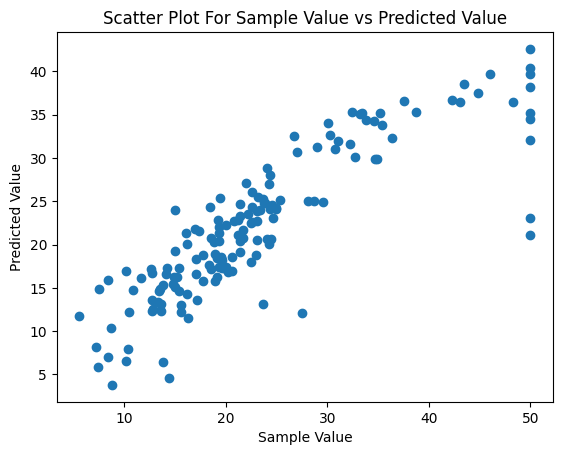

In [108]:
prediction = prediction.toPandas()
plt.scatter(prediction["medv"],prediction["predicted_train"])
plt.xlabel("Sample Value")
plt.ylabel("Predicted Value")
plt.title("Scatter Plot For Sample Value vs Predicted Value")
plt.show()